In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Create a function to calculate ECDF given a column series
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y  

In [3]:
# Import the no-hitter baseball dataset from csv
df = pd.read_csv('https://assets.datacamp.com/production/repositories/470/datasets/593c37a3588980e321b126e30873597620ca50b7/mlb_nohitters.csv')

In [4]:
df.head()

,date,game_number,winning_team,losing_team,winning_pitcher
0,18760715,140,NaN,NaN,NaN
1,18800612,1035,NaN,NaN,NaN
2,18800617,1046,NaN,NaN,NaN
3,18800819,1177,NaN,NaN,NaN
4,18800820,1179,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             294 non-null    int64 
 1   game_number      294 non-null    int64 
 2   winning_team     228 non-null    object
 3   losing_team      228 non-null    object
 4   winning_pitcher  228 non-null    object
dtypes: int64(2), object(3)
memory usage: 11.6+ KB


In [6]:
df['Date'] = df.date.astype('str')
df['Date'] = pd.to_datetime(df.Date, format="%Y%m%d")

In [7]:
df['timedelta'] = df.game_number.diff() - 1

In [8]:
df.head()

,date,game_number,winning_team,losing_team,winning_pitcher,Date,timedelta
0,18760715,140,NaN,NaN,NaN,1876-07-15,NaN
1,18800612,1035,NaN,NaN,NaN,1880-06-12,894.0
2,18800617,1046,NaN,NaN,NaN,1880-06-17,10.0
3,18800819,1177,NaN,NaN,NaN,1880-08-19,130.0
4,18800820,1179,NaN,NaN,NaN,1880-08-20,1.0


In [9]:
df.Date.max()

Timestamp('2015-10-03 00:00:00')

## Create "Modern" subset of data (1901-2015)

In [10]:
modern = df.query('Date > "1900-12-31"')

In [11]:
df.Date.min()

Timestamp('1876-07-15 00:00:00')

In [12]:
modern.Date.min()

Timestamp('1901-07-15 00:00:00')

## How often do we get no-hitters?

If you assume that no-hitters are described as a Poisson process, then the time between no-hitters is Exponentially distributed. As you have seen, the Exponential distribution has a single parameter, which we will call $\tau$, the typical interval time. The value of the parameter $\tau$ that makes the exponential distribution best match the data is the mean interval time (where time is in units of number of games) between no-hitters.

In [13]:
# Create series from timedelta column for time (in games) between no-hitter games
nohitter_times = modern.timedelta

In [14]:
# Seed random number generator
np.random.seed(42)

# Compute mean no-hitter time: tau
tau = np.mean(nohitter_times)

# Draw out of an exponential distribution with parameter tau: inter_nohitter_time
inter_nohitter_time = np.random.exponential(tau, 100000)

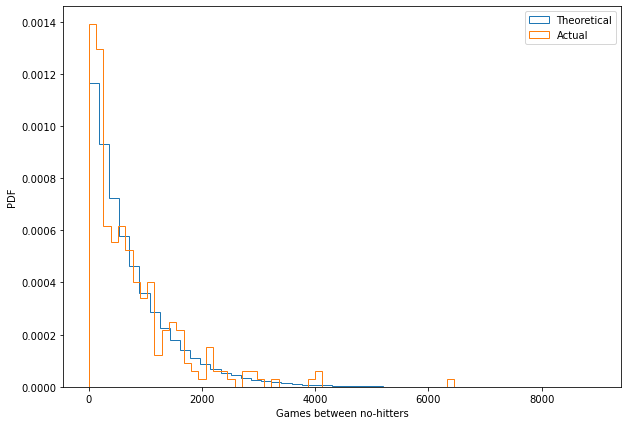

In [15]:
# Plot out the theoretical PDF and the actual data to see if it has an exponential distribution
# which we would expect if it follows a Poisson distribution (rare events)
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(inter_nohitter_time, bins=50, histtype='step', density=True, label='Theoretical')
plt.hist(nohitter_times, bins=50, histtype='step', density=True, label='Actual')
plt.xlabel('Games between no-hitters')
plt.ylabel('PDF')
plt.legend()

### Examine the data using an ECDF plot

In [16]:
# Create an ECDF from real data: x, y
x, y = ecdf(nohitter_times)

# Create a CDF from theoretical samples: x_theor, y_theor
x_theor, y_theor = ecdf(inter_nohitter_time)

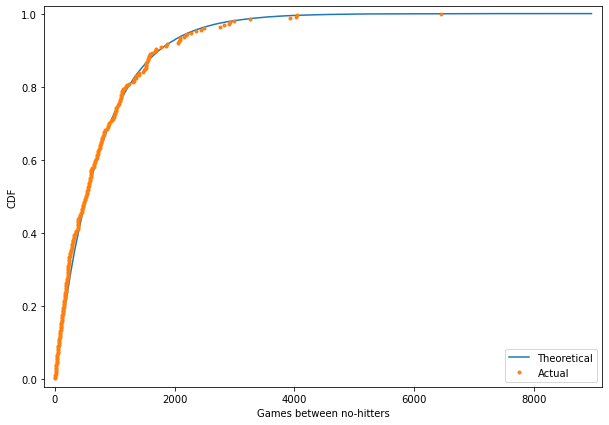

In [17]:
# Overlay the plots
fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x_theor, y_theor, label="Theoretical")
plt.plot(x,y, marker='.', linestyle='none', label='Actual')

# Margins and axis labels
plt.margins(0.02)
plt.xlabel('Games between no-hitters')
plt.ylabel('CDF')
plt.legend(loc='lower right')

It looks like no-hitters in the modern era of Major League Baseball are Exponentially distributed. Based on the story of the Exponential distribution, this suggests that they are a random process; when a no-hitter will happen is independent of when the last no-hitter was.

## Examine p-value of "dead ball" rule changes on no-hitter data
In 1920, Major League Baseball implemented important rule changes that ended the so-called dead ball era. Importantly, the pitcher was no longer allowed to spit on or scuff the ball, an activity that greatly favors pitchers. In this problem you will perform an A/B test to determine if these rule changes resulted in a slower rate of no-hitters (i.e., longer average time between no-hitters) using the difference in mean inter-no-hitter time as your test statistic.

In [19]:
# Make a function to create a test statistic of the difference of the means of data
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [20]:
# Create a function to generate permutation replicates with a passed function as a test statistic
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

### Create two arrays of the inter-no-hitter times split into before the rule change in 1920 and after

In [21]:
df.head()

,date,game_number,winning_team,losing_team,winning_pitcher,Date,timedelta
0,18760715,140,NaN,NaN,NaN,1876-07-15,NaN
1,18800612,1035,NaN,NaN,NaN,1880-06-12,894.0
2,18800617,1046,NaN,NaN,NaN,1880-06-17,10.0
3,18800819,1177,NaN,NaN,NaN,1880-08-19,130.0
4,18800820,1179,NaN,NaN,NaN,1880-08-20,1.0


In [29]:
dead = df.query('Date < 19200101')

In [30]:
live = df.query('Date > 19191231')

In [31]:
nht_dead = dead.timedelta
nht_dead[0] = -1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
nht_live = live.timedelta

In [33]:
nht_live

91      645.0
92     2088.0
93       42.0
94     2090.0
95       11.0
        ...  
289     419.0
290     239.0
291     119.0
292     129.0
293     467.0
Name: timedelta, Length: 203, dtype: float64